In [1]:
import stan as st
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from IPython.core.debugger import Pdb #Pdb().set_trace()

pd.options.mode.chained_assignment = None  # default='warn'

sstyle = "seaborn-poster"
plt.style.use(sstyle)
plt.rc('font',family = 'serif')

contaminants = ['CO_ppm', 'NOX_ppb', 'O3_ppb', 'SO2_ppb']

Data from the [Mexico City Atmospheric Monitoring System (SIMAT)](http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmI=%27&opcion=Zg==)

In [2]:
def get_data(year,zone,print_locs=False):
    # Creating dictionary to retrieve units from id
    units = (
        pd.read_csv("data/info_parameters/cat_unidades.csv", 
                    encoding="latin-1")
        .rename(columns={"clave_unidad":"unit"})
        .drop(columns=["nombre_unidad"])
        .set_index("id_unidad")
    )["unit"].to_dict()
    # Reading data per year
    df = (
        pd.read_csv(f"data/contaminantes_{year}.csv",
                    skiprows=10).rename(columns={"unit":"id_unidad"})
    )
    df["units"] = df.id_unidad.map(units); df = df.drop(columns=["id_unidad"])
    if print_locs:
        print(f"Available zones for this dataset: {df.id_station.unique()}")    
    df = df[df.id_station.isin([zone])]; df = df.drop(columns=["id_station"])
    # Getting datasets per contaminat
    contaminants = df.id_parameter.unique(); DF_c = []
    for c in contaminants:
        df_ = df[df.id_parameter.isin([c])]
        df_.date = (
            pd.to_datetime(
                df_.date.str.replace(" 24:00"," 00:00"),
                format="%d/%m/%Y %H:%M"
            )
        )
        df_.reset_index(inplace=True)
        c_name_unit = ((df_.id_parameter.unique()[0], df_.units.unique()[0]))
        df_.rename(columns={"value":f"{c_name_unit[0]}_{c_name_unit[-1]}"},inplace=True)
        df_.drop(["id_parameter","index","units"], axis=1, inplace=True)
        DF_c.append(df_)  
    # Creating a dataframe instead of a list of dataframes.
    DF_ = DF_c[0]
    for df_ in DF_c[1:]:
        df_.drop(["date"], axis=1, inplace=True)
        DF_ = pd.concat([DF_, df_], axis=1) 
    #Outputting specific contaminants    
    return DF_.set_index("date")

In [3]:
cc  = 0 # position of contaminant in list
loc = "NEZ" # location to be studied
year = 2019 # year to be studied

df = get_data(year,loc,True)[contaminants]

Available zones for this dataset: ['ACO' 'AJU' 'ATI' 'CAM' 'MON' 'CHO' 'COY' 'CUA' 'CUT' 'FAC' 'HGM' 'IZT'
 'LLA' 'LPR' 'MER' 'NEZ' 'PED' 'SAG' 'SFE' 'SJA' 'TAH' 'TLA' 'TLI' 'UAX'
 'UIZ' 'VIF' 'XAL' 'CCA' 'MGH' 'AJM' 'MPA' 'BJU' 'INN' 'GAM' 'FAR' 'SAC']


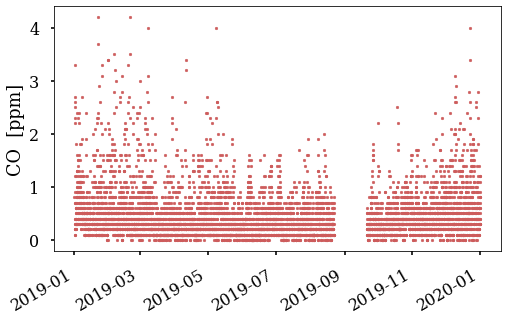

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(df.index, df[contaminants[cc]], s=7, c="indianred")
plt.gcf().autofmt_xdate()
plt.ylabel((contaminants[cc].replace("_", "  [")+"]").replace("X","$_X$"));
#plt.savefig(f"{contaminants[cc]}.pdf", format="pdf");

In [5]:
# Prints the total non-nan values per colum
len(df) - df.count()

CO_ppm     1129
NOX_ppb    1872
O3_ppb     1478
SO2_ppb    5387
dtype: int64